In [2]:
# Seed value
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

In [3]:
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import auc, roc_curve, accuracy_score, balanced_accuracy_score, f1_score, recall_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [1]:
!pip install pyarrow

# Load Test Data
- Load data from parquet or csv
- Map 'Heartbleed' and 'Infiltration' attack classes to 'Unknown'

In [7]:
test = pd.read_parquet("data/test.parquet")
# test = pd.read_csv("data/test.csv")

y = test["Y"].replace(["Heartbleed", "Infiltration"], "Unknown")
x = test.drop(columns=['Y'])

y.value_counts()

Y
Benign         56468
(D)DOS           584
Port Scan        584
Botnet           584
Brute Force      584
Web Attack       584
Unknown           47
Name: count, dtype: int64

### Load additional infiltration samples from 2018

In [1]:
infiltration_2018 = pd.read_parquet("data/infiltration_2018.parquet")

y_18 = infiltration_2018['y']
x_18 = infiltration_2018.drop(columns=['y'])

y_18.value_counts()

NameError: name 'pd' is not defined

# Load Models
- the pipelines with feature scaler and optimized model combined for binary detection and multi-class classification
- the individual feature scalers and optimized models
- Random Forest (RF) optimized baseline model and feature scaler
- Optimized models following Bovenzi et al. for comparitative analysis

In [6]:
# Optimized pipelines
f = open("models/stage1_ocsvm.p","rb")
stage1 = pickle.load(f)
f.close()
f = open("models/stage2_rf.p","rb")
stage2 = pickle.load(f)
f.close()

# Individual feature scalers and classification models
f = open("models/stage1_ocsvm_model.p","rb")
stage1_model = pickle.load(f)
f.close()
f = open("models/stage1_ocsvm_scaler.p","rb")
stage1_scaler = pickle.load(f)
f.close()
f = open("models/stage2_rf_model.p","rb")
stage2_model = pickle.load(f)
f.close()
f = open("models/stage2_rf_scaler.p","rb")
stage2_scaler = pickle.load(f)
f.close()

# RF baseline model and feature scaler
f = open("models/baseline_rf.p","rb")
baseline_rf = pickle.load(f)
f.close()
f = open("models/baseline_rf_scaler.p","rb")
baseline_rf_scaler = pickle.load(f)
f.close()

# Optimized models for Bovenzi et al.
from tensorflow import keras
sota_stage1 = keras.models.load_model("models/sota_stage1.h5")
f = open("models/sota_stage2.p","rb")
sota_stage2 = pickle.load(f)
f.close()

c:\Users\henri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.1.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\henri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\henri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator One

ValueError: node array from the pickle has an incompatible dtype:
- expected: {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}
- got     : [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]

In [8]:
stage1

Pipeline(steps=[('scaler',
                 QuantileTransformer(output_distribution='normal',
                                     subsample=100000)),
                ('pca', PCA(n_components=56, random_state=42)),
                ('ocsvm',
                 OneClassSVM(gamma=0.0632653906314333, nu=0.0002316646233151,
                             verbose=True))])

In [9]:
stage2

Pipeline(steps=[('scaler',
                 QuantileTransformer(output_distribution='normal',
                                     subsample=100000)),
                ('rf',
                 RandomForestClassifier(max_features=0.1751204590963604,
                                        max_samples=0.9034128710297624,
                                        n_estimators=97, random_state=42))])

In [10]:
baseline_rf

RandomForestClassifier(max_features=0.4529830442627406,
                       max_samples=0.8736817640465646, n_estimators=57,
                       oob_score=True, random_state=42)

In [11]:
sota_stage1

In [12]:
sota_stage2

RandomForestClassifier(max_features=0.15532254178732274,
                       max_samples=0.9777860112712836, n_estimators=70,
                       random_state=42)

# Thresholds $\tau_B$, $\tau_M$ and $\tau_U$
These balanced thresholds are experimentally obtained, see full paper for more details.

In [13]:
tau_b = -0.0002196942507948895
tau_m = 0.98
tau_u = 0.0040588613744241275

# Evaluation of Time Complexity

In [14]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

`hids_predict`: Function to preform classification of all stages combined of the novel hierarchical multi-stage intrusion detection approach by Verkerken et al.

`hids_sota_predict`: Function to evaluate former SotA approach existing of two stages by Bovenzi et al.

In [45]:
def hids_predict(x, tau_b, tau_m, tau_u):
    proba_1 = -stage1.decision_function(x) # invert sign to act as anomaly score 
    pred_1 = np.where(proba_1 < tau_b, "Benign", "Attack").astype(object)
    proba_2 = stage2.predict_proba(x[pred_1 == "Attack"])
    pred_2 = np.where(
        np.max(proba_2, axis=1) > tau_m, 
        stage2.classes_[np.argmax(proba_2, axis=1)], 
        "Unknown")
    proba_3 = proba_1[pred_1 == "Attack"][pred_2 == "Unknown"]
    pred_3 = np.where(proba_3 < tau_u, "Benign", "Unknown")
    pred_1[pred_1 == "Attack"] = pred_2
    pred_1[pred_1 == "Unknown"] = pred_3
    return pred_1

In [35]:
def hids_sota_predict(x, tau_b, tau_m):
    x_s = stage1_scaler.transform(x)
    x_pred = sota_stage1.predict(x_s)
    proba_1 = np.sum((x_s - x_pred)**2, axis=1)
    pred_1 = np.where(proba_1 < tau_b, "Benign", "Attack").astype(object)
    x_s = stage2_scaler.transform(x)
    proba_2 = sota_stage2.predict_proba(x_s[pred_1 == "Attack"])
    pred_1[pred_1 == "Attack"] = np.where(
        np.max(proba_2, axis=1) > tau_m, 
        stage2.classes_[np.argmax(proba_2, axis=1)], 
        "Unknown")
    return pred_1

### Max F-score thesholds

In [25]:
%%timeit -r3 -n3 -p6
tau_b = -0.0002196942507948895
tau_m = 0.98
tau_u = 0.004530129828299084
y = hids_predict(x, tau_b, tau_m, tau_u)

7.80801 s ± 8.89491 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Max bACC thresholds

In [26]:
%%timeit -r3 -n3 -p6
tau_b = -0.0004064190600459828
tau_m = 0.98
tau_u = 0.0006590265510403005
y = hids_predict(x, tau_b, tau_m, tau_u)

8.04311 s ± 65.1999 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Best "balanced" thesholds

In [27]:
%%timeit -r3 -n3 -p6
tau_b = -0.0002196942507948895
tau_m = 0.98
tau_u = 0.0040588613744241275
y = hids_predict(x, tau_b, tau_m, tau_u)

7.88245 s ± 53.5954 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Baseline RF

In [31]:
threshold = 0.43

In [32]:
%%timeit -r3 -n3 -p6
x_s = baseline_rf_scaler.transform(x)
y_proba = baseline_rf.predict_proba(x_s)
y_pred = np.where(np.max(y_proba, axis=1) > threshold, baseline_rf.classes_[np.argmax(y_proba, axis=1)], 'Unknown')

1.52463 s ± 12.5652 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Bovenzi et al.

In [25]:
# Thresholds experimentally optimized
tau_b = 0.7580776764761945
tau_m = 0.98

In [38]:
%%timeit -r3 -n3 -p6
y = hids_sota_predict(x, tau_b, tau_m)

1858/1858 [==============================] - 3s 2ms/step
6.96949 s ± 399.393 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Single sample
Inference time for predicting a single flow

In [10]:
sample = np.array(x.values[0]).reshape(1, -1)
sample

array([[ 6.00000000e+00,  3.00000000e+00,  2.00000000e+00,
         0.00000000e+00,  1.20000000e+01,  0.00000000e+00,
         6.00000000e+00,  6.00000000e+00,  6.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  4.00000000e+06,
         6.66666688e+05,  3.00000000e+00,  0.00000000e+00,
         3.00000000e+00,  3.00000000e+00,  3.00000000e+00,
         3.00000000e+00,  0.00000000e+00,  3.00000000e+00,
         3.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  4.00000000e+01,  0.00000000e+00,
         6.66666688e+05,  0.00000000e+00,  6.00000000e+00,
         6.00000000e+00,  6.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         9.00000000e+00,  6.00000000e+00,  0.00000000e+0

In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [12]:
%%timeit -n 10 -r 10
x_s = stage1_scaler.transform(sample)
proba = -stage1_model.decision_function(x_s)
pred = np.where(proba < tau_b, "Benign", "Attack").astype(object)

60.3 ms ± 2.08 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [13]:
%%timeit -n 10 -r 10
x_s = stage2_scaler.transform(sample)
proba = stage2_model.predict_proba(x_s)
pred_2 = np.where(
    np.max(proba, axis=1) > tau_m, 
    stage2_model.classes_[np.argmax(proba, axis=1)], 
    "Unknown")

73.2 ms ± 836 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [17]:
%%timeit -n 10 -r 10
proba_1 = -stage1.decision_function(sample) # invert sign to act as anomaly score 
pred_1 = np.where(proba_1 < tau_b, "Benign", "Attack").astype(object)

59.9 ms ± 622 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [18]:
%%timeit -n 10 -r 10
proba_2 = stage2.predict_proba(sample)
pred_2 = np.where(
    np.max(proba_2, axis=1) > tau_m, 
    stage2.classes_[np.argmax(proba_2, axis=1)], 
    "Unknown")

74.3 ms ± 724 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


# Evaluate Multi-Stage Model

## Stage 1: Binary Detection

In [15]:
proba_1 = -stage1.decision_function(x) # invert sign to act as anomaly score 
pred_1 = np.where(proba_1 < tau_b, "Benign", "Attack").astype(object)
np.unique(pred_1, return_counts=True)

(array(['Attack', 'Benign'], dtype=object), array([20541, 38894]))

In [20]:
%%timeit -n3 -r3
proba_1 = -stage1.decision_function(x) # invert sign to act as anomaly score 
pred_1 = np.where(proba_1 < tau_b, "Benign", "Attack").astype(object)
np.unique(pred_1, return_counts=True)

7.19 s ± 4.28 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


## Stage 2: Multi-Class Classification

In [9]:
proba_2 = stage2.predict_proba(x[pred_1 == "Attack"])
pred_2 = np.where(
    np.max(proba_2, axis=1) > tau_m, 
    stage2.classes_[np.argmax(proba_2, axis=1)], 
    "Unknown")
np.unique(pred_2, return_counts=True)

(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
        'Web Attack'], dtype=object),
 array([  547,   746,   570,   594, 17543,   541]))

In [16]:
%%timeit -n3 -r3
proba_2 = stage2.predict_proba(x[pred_1 == "Attack"])
pred_2 = np.where(
    np.max(proba_2, axis=1) > tau_m, 
    stage2.classes_[np.argmax(proba_2, axis=1)], 
    "Unknown")
np.unique(pred_2, return_counts=True)

603 ms ± 9.47 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


## Extension Stage: Zero-Day Detection

In [10]:
proba_3 = proba_1[pred_1 == "Attack"][pred_2 == "Unknown"]
pred_3 = np.where(proba_3 < tau_u, "Benign", "Unknown")
np.unique(pred_3, return_counts=True)

(array(['Benign', 'Unknown'], dtype='<U7'), array([16955,   588]))

## Combine stages

In [11]:
y_pred = pred_1.copy()
y_pred[y_pred == "Attack"] = pred_2
y_pred[y_pred == "Unknown"] = pred_3
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  547, 55849,   746,   570,   594,   588,   541]))

# Statistics and Visualizations of the Results

In [12]:
def plot_confusion_matrix(y_true, y_pred, figsize=(7,7), cmap="Blues", values=[-1, 1], labels=["Attack", "Benign"], title="", ax=None, metrics=False):
    cm = confusion_matrix(y_true, y_pred, labels=values)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float)
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            annot[i, j] = '%.1f%%\n%d' % (p * 100, c)
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, cmap=cmap, annot=annot, fmt='', ax=ax, vmin=0, vmax=1)
    if title != "":
        ax.set_title(title)

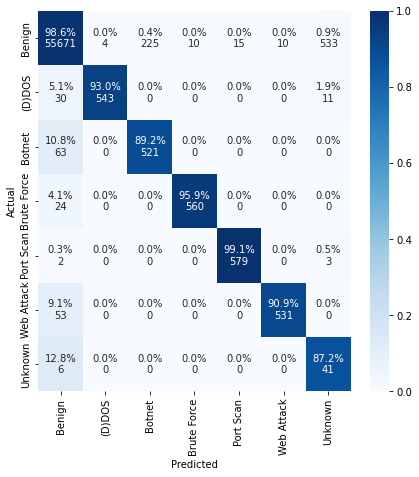

In [13]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
plot_confusion_matrix(y, y_pred, values=classes, labels=classes, metrics=True)

In [14]:
print(classification_report(y, y_pred, digits=4))

              precision    recall  f1-score   support

      (D)DOS     0.9927    0.9298    0.9602       584
      Benign     0.9968    0.9859    0.9913     56468
      Botnet     0.6984    0.8921    0.7835       584
 Brute Force     0.9825    0.9589    0.9705       584
   Port Scan     0.9747    0.9914    0.9830       584
     Unknown     0.0697    0.8723    0.1291        47
  Web Attack     0.9815    0.9092    0.9440       584

    accuracy                         0.9834     59435
   macro avg     0.8138    0.9342    0.8231     59435
weighted avg     0.9926    0.9834    0.9875     59435



## Robustness - Preform classification on additional "infiltration" samples from cic-ids-2018

In [53]:
tau_b = -0.0002196942507948895
tau_m = 0.98
tau_u = 0.0040588613744241275 # balanced threshold -> 29,02% recall on infiltration 2018
# tau_u = 0.0006590265510403005 # bACC threshold -> 78,38% recall on infiltration 2018
y = hids_predict(x_18, tau_b, tau_m, tau_u)

In [54]:
np.unique(y, return_counts=True)

(array(['(D)DOS', 'Benign', 'Unknown'], dtype=object),
 array([   11, 90734, 37099]))

In [50]:
np.unique(y, return_counts=True)

(array(['(D)DOS', 'Benign', 'Unknown'], dtype=object),
 array([    11,  27634, 100199]))

In [57]:
tau_b = 0.7580776764761945
tau_m = 0.98
y = hids_sota_predict(x_18, tau_b, tau_m) # 86.99% recall on infiltration 2018

3996/3996 [==============================] - 6s 2ms/step


In [58]:
np.unique(y, return_counts=True)

(array(['(D)DOS', 'Benign', 'Unknown', 'Web Attack'], dtype=object),
 array([     4,  16624, 111215,      1]))

In [59]:
x_s = baseline_rf_scaler.transform(x_18)
y_proba = baseline_rf.predict_proba(x_s)
y_pred = np.where(np.max(y_proba, axis=1) > 0.43, baseline_rf.classes_[np.argmax(y_proba, axis=1)], 'Unknown')
# 0.06% recall on infiltration 2018

In [61]:
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  3445, 123511,    619,     22,     30,     76,    141]))